In [3]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, PFNanoAODSchema
import json
import fastjet
import numpy as np
import awkward as ak
from coffea import processor
import hist
import coffea.nanoevents.methods.vector as vector
import warnings
import hist.dask as dhist
import dask
import pickle
from coffea.ml_tools.torch_wrapper import torch_wrapper
import pandas as pd
import matplotlib.pyplot as plt
import hist
from sklearn.metrics import roc_curve, auc

In [14]:
qcd = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/qcd.parquet')
ttboosted = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/ttboosted.parquet')
wqq = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/wqq.parquet')
zqq = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/zqq.parquet')
singletop = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/singletop.parquet')
ww = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/ww.parquet')
wz = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/wz.parquet')
zz = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/zz.parquet')

In [16]:
background = ak.concatenate([qcd, ttboosted, wqq, zqq, singletop, ww, wz, zz])

In [18]:
background = background[background['FatJets.msoftdrop'] < 140]
background = background[background['FatJets.msoftdrop'] > 90]
background = background[background['FatJets.pt'] < 600]
background = background[background['FatJets.pt'] > 450]
background['FatJets.mratio'] = background['FatJets.mass']/background['FatJets.msoftdrop']

In [19]:
hbb = ak.from_parquet('/scratch365/cmoore24/training/data/no_subcut/hbb.parquet')

In [20]:
pick = hbb
pick = pick[pick['FatJets.msoftdrop'] < 140]
pick = pick[pick['FatJets.msoftdrop'] > 90]
pick = pick[pick['FatJets.pt'] < 600]
pick = pick[pick['FatJets.pt'] > 450]
pick['FatJets.mratio'] = pick['FatJets.mass']/pick['FatJets.msoftdrop']

In [21]:
model = 'models_and_scalers/all/hbb_nosubcut_traced_model.pt'
with open('models_and_scalers/all/hbb_nosubcut_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [22]:
class ParticleNetExample1(torch_wrapper):
    def prepare_awkward(self, events, scaler):
        fatjets = events

        imap = {
            'vars': {
                'n2b1': fatjets['FatJets.n2b1'],
                'n3b1': fatjets['FatJets.n3b1'],
                'nConstituents': fatjets['FatJets.nConstituents'],
                #'color_ring': fatjets['FatJets.color_ring'],
                'd2b1': fatjets['FatJets.d2b1'],
                'u1': fatjets['FatJets.u1'],
                'u2': fatjets['FatJets.u2'],
                'u3': fatjets['FatJets.u3'],
                'd3': fatjets['FatJets.d3'],
                'm2': fatjets['FatJets.m2'],
                'm3': fatjets['FatJets.m3'],
                'n4': fatjets['FatJets.n4'],
                #'mratio': fatjets['FatJets.mratio'],
            },
        }

        retmap = {
            k: ak.concatenate([x[:, np.newaxis] for x in imap[k].values()], axis=1)
            for k in imap.keys()
        }
        x = ak.values_astype(scaler.transform(retmap['vars']), "float32")
        return (x,), {}

In [23]:
a = ParticleNetExample1(model)
sig_score = a(pick, scaler)[:,0]
bkg_score = a(background, scaler)[:,0]

/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea2024/lib/python3.10/site-packages/coffea/ml_tools/helper.py:175: UserWarning: No format checks were performed on input!
  warnings.warn("No format checks were performed on input!")
/afs/crc.nd.edu/user/c/cmoore24/miniconda3/envs/coffea2024/lib/python3.10/site-packages/coffea/ml_tools/helper.py:175: UserWarning: No format checks were performed on input!
  warnings.warn("No format checks were performed on input!")


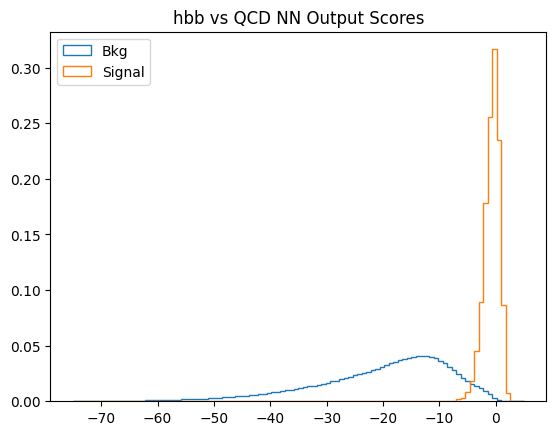

In [35]:
plt.hist(bkg_score, range=(-75, 5), bins=100, label='Bkg', density=True, histtype='step')
plt.hist(sig_score, range=(-75, 5), bins=100, label='Signal', density=True, histtype='step')
plt.title(f'hbb vs QCD NN Output Scores')
plt.legend()
plt.show()

In [36]:
print(ak.min(bkg_score))
print(ak.min(sig_score))

-213.57689
-18.195848


In [37]:
print(ak.max(bkg_score))
print(ak.max(sig_score))

2.2308626
2.3019454


In [40]:
214+3

217

In [41]:
bkg_bins = 217
bkg_min = 214
bkg_max = 3

In [42]:
19+3

22

In [43]:
sig_bins = 22
sig_min = 19
sig_max = 3

In [44]:
bkg_hist = hist.Hist.new.Reg(bkg_bins, -bkg_min, bkg_max, name="Bkg_NN", label="Bkg_NN", overflow=False, underflow=False).Weight()
bkg_hist.fill(Bkg_NN=bkg_score);

In [45]:
sig_hist = hist.Hist.new.Reg(sig_bins, -sig_min, sig_max, name="Sig_NN", label="Sig_NN", overflow=False, underflow=False).Weight()
sig_hist.fill(Sig_NN=sig_score);

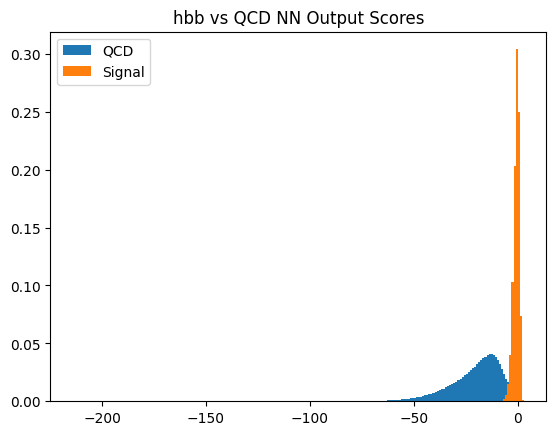

In [47]:
fig, ax = plt.subplots()
bkg_hist.plot1d(density=True, label='QCD', histtype='fill')
sig_hist.plot1d(density=True, label='Signal', histtype='fill')
plt.title(f'hbb vs QCD NN Output Scores')
plt.xlabel('')
plt.legend()
plt.show()

In [48]:
bkg_zeros = ak.zeros_like(bkg_score)
sig_ones = ak.ones_like(sig_score)
combined = ak.concatenate([bkg_score,sig_score])
combined_truth = ak.concatenate([bkg_zeros, sig_ones])

In [49]:
bkg_total = bkg_hist[0:bkg_bins:sum]
sig_total = sig_hist[0:sig_bins:sum]

In [67]:
wp = 0

In [68]:
bkg_wp_value = bkg_hist[bkg_min+wp:bkg_bins:sum]
sig_wp_value = sig_hist[sig_min+wp:sig_bins:sum]

In [55]:
bkg_ratio = bkg_wp_value.value/bkg_total.value

In [56]:
sig_ratio = sig_wp_value.value/sig_total.value

In [69]:
bkg_wp_ratios = []
sig_wp_ratios = []
for i in range(-10, 2, 2):
    bkg_wp_value = bkg_hist[bkg_min+i:bkg_bins:sum]
    bkg_wp_ratios.append(bkg_wp_value.value/bkg_total.value)

    sig_wp_value = sig_hist[sig_min+i:sig_bins:sum]
    sig_wp_ratios.append(sig_wp_value.value/sig_total.value)

In [70]:
pick['FatJets.isSignal'] = np.ones_like(pick['FatJets.particleNetMD_QCD'])
background['FatJets.isSignal'] = np.zeros_like(background['FatJets.particleNetMD_QCD'])

In [71]:
arg1 = ak.concatenate([pick['FatJets.isSignal'], background['FatJets.isSignal']])
arg2 = ak.concatenate([pick['FatJets.particleNetMD_QCD'], background['FatJets.particleNetMD_QCD']])

arg3 = ak.concatenate([pick['FatJets.particleNet_HbbvsQCD'], background['FatJets.particleNet_HbbvsQCD']])

fpr2, tpr2, thresholds2 = roc_curve(arg1, arg2)
fpr3, tpr3, thresholds3 = roc_curve(arg1, arg3)

roc_auc2 = auc(tpr2, fpr2)
roc_auc3 = auc(fpr3, tpr3)

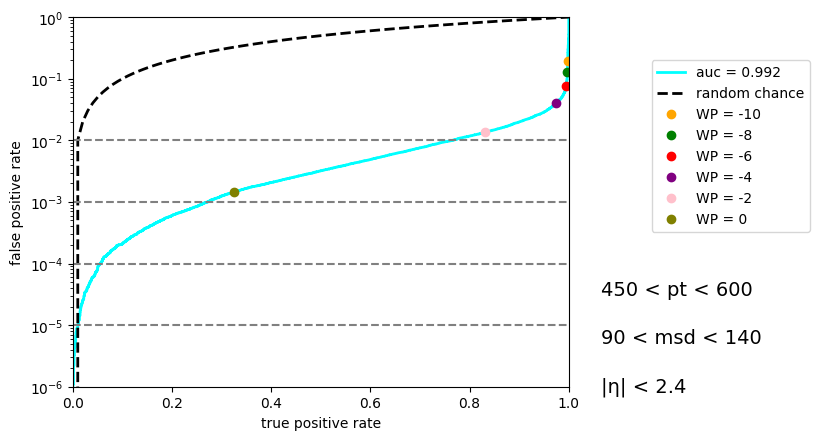

In [73]:
fig, ax = plt.subplots()
fpr, tpr, thresholds = roc_curve(combined_truth, combined)
roc_auc = auc(fpr, tpr)
ax.set_yscale("log")
ax.plot(tpr, fpr, lw=2, color="cyan", label="auc = %.3f" % (roc_auc))
# ax.plot(fpr2, tpr2, lw=2, color="red", label="PN_MD_QCD auc = %.3f" % (roc_auc2))
# ax.plot(tpr3, fpr3, lw=2, color="orange", label="PN_HbbvQCD auc = %.3f" % (roc_auc3))
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), linestyle="--", lw=2, color="k", label="random chance")
ax.set_xlim([0, 1.0])
ax.set_ylim([1e-6, 1.0])
ax.set_xlabel("true positive rate")
ax.set_ylabel("false positive rate")
#ax.set_title(f"{title} ROC curve")

ax.plot(sig_wp_ratios[0], bkg_wp_ratios[0], 'o', color='orange', label='WP = -10')
ax.plot(sig_wp_ratios[1], bkg_wp_ratios[1], 'o', color='green', label='WP = -8')
ax.plot(sig_wp_ratios[2], bkg_wp_ratios[2], 'o', color='red', label='WP = -6')
ax.plot(sig_wp_ratios[3], bkg_wp_ratios[3], 'o', color='purple', label='WP = -4')
ax.plot(sig_wp_ratios[4], bkg_wp_ratios[4], 'o', color='pink', label='WP = -2')
ax.plot(sig_wp_ratios[5], bkg_wp_ratios[5], 'o', color='olive', label='WP = 0')

ax.axhline(y=1e-2, color='grey', linestyle='--')
ax.axhline(y=1e-3, color='grey', linestyle='--')
ax.axhline(y=1e-4, color='grey', linestyle='--')
ax.axhline(y=1e-5, color='grey', linestyle='--')

ax.legend(loc="lower right", bbox_to_anchor=(1.5, 0.4))

plt.gcf().text(0.95, 0.3, '450 < pt < 600', fontsize=14)
plt.gcf().text(0.95, 0.2, '90 < msd < 140', fontsize=14)
plt.gcf().text(0.95, 0.1, '|η| < 2.4', fontsize=14)

plt.show()